# Multivariate, Multi-step Time Series Forecasting with _Seq2Seq_ deep learning


The power consumption dataset is a multivariate time series of power-related variables which in this example will be used for modeling one of its features. The 7 features/attributes (except the date and time) are as follows:

1. global_active_power: The total active power consumed by the household (kilowatts).
1. global_reactive_power: The total reactive power consumed by the household (kilowatts).
1. voltage: Average voltage (volts).
1. global_intensity: Average current intensity (amps).
1. sub_metering_1: Active energy for kitchen (watt-hours of active energy).
1. sub_metering_2: Active energy for laundry (watt-hours of active energy).
1. sub_metering_3: Active energy for climate control systems (watt-hours of active energy).


For _active_ and _reactive_ energy refer to the technical details of [alternative current](https://en.wikipedia.org/wiki/AC_power).

A fourth sub-metering variable can be created by subtracting the sum of three defined sub-metering variables from the total active energy as follows:
```
sub_metering_remainder = (global_active_power * 1000 / 60) - (sub_metering_1 + sub_metering_2 + sub_metering_3)
```

__Predict for _Global_active_power_ attribute/feature.__

[Dataset reference](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption)

In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, RepeatVector, TimeDistributed
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [3]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

No GPU found


### Load pre-processed data

In [4]:
path_to_files = "D:/Deep_Learning_resources/Sequence_Modelling_resources/Datasets/Household_Power_Consumption-files/"

In [5]:
# Read in day-wise aggregated and processed data-
data = pd.read_csv(path_to_files + "household_power_consumption_cleaned-days_grouping.csv")

In [6]:
data.shape

(1442, 9)

In [7]:
data.columns

Index(['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'sub_metering_4'],
      dtype='object')

In [8]:
data.dtypes

datetime                  object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
sub_metering_4           float64
dtype: object

In [9]:
data.isna().values.any()

False

In [10]:
# Convert to 'datetime64' format-
data['datetime'] = pd.to_datetime(data['datetime'])

In [11]:
# Sort in ascending order-
data.sort_values(by = 'datetime', inplace = True)

In [12]:
# Drop index-
data.reset_index(drop = True, inplace = True)

In [13]:
# Get min and max date times-
data['datetime'].min(), data['datetime'].max()

(Timestamp('2006-12-16 00:00:00'), Timestamp('2010-11-26 00:00:00'))

In [14]:
# Sanity check-
data.dtypes

datetime                 datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
sub_metering_4                  float64
dtype: object

In [15]:
data.head(7)

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.934
1,2006-12-17,3390.460,226.006,345725.30,14398.6,2033.0,4187.0,13341.0,36946.668
2,2006-12-18,2203.826,161.792,347373.62,9247.2,1063.0,2621.0,14018.0,19028.434
3,2006-12-19,1666.194,150.942,348479.00,7094.0,839.0,7602.0,6197.0,13131.900
4,2006-12-20,2225.748,160.998,348923.62,9313.0,0.0,2648.0,14063.0,20384.800
5,2006-12-21,1723.288,144.434,347096.40,7266.4,1765.0,2692.0,10456.0,13808.467
6,2006-12-22,2341.338,186.906,347305.75,9897.0,3151.0,350.0,11131.0,24390.300


In [16]:
# Get basic data statistics-
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,1567.839070,178.004759,346600.529438,6646.587101,1609.656033,1858.135229,9280.574202,13382.285707
std,597.306856,48.881691,7375.850078,2472.108923,1581.726035,2085.161400,3674.915577,6071.784572
min,250.298000,34.922000,93552.530000,1164.000000,0.000000,0.000000,1288.000000,2313.633300
25%,1176.195000,143.063000,345736.797500,5055.400000,700.000000,432.500000,6681.000000,9400.766500
50%,1543.253000,171.199000,346979.440000,6539.300000,1119.000000,696.000000,9272.000000,12634.700000
75%,1894.467500,202.548500,348283.380000,7965.600000,2201.750000,2732.000000,11764.000000,16498.225250
max,4773.386000,417.834000,356306.400000,20200.400000,11178.000000,12109.000000,23743.000000,61736.434000


In [17]:
# Seems to be an outlier-
data[data['Voltage'] <= 100000]

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.934


In [18]:
data['Voltage'].mean()

346600.5294382793

In [19]:
# Replace outlier value with mean value-
data.loc[data['Voltage'] <= 100000, 'Voltage'] = data['Voltage'].mean()

In [20]:
# Sanity check-
data[data['Voltage'] <= 100000]

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4


In [21]:
# data['datetime'].min(), data['datetime'].max()
data.loc[0, 'datetime'], data.loc[len(data) - 1, 'datetime']

(Timestamp('2006-12-16 00:00:00'), Timestamp('2010-11-26 00:00:00'))

In [22]:
# Select required columns-
reqd_cols = data.columns.tolist()
reqd_cols.remove('datetime')

In [23]:
reqd_cols

['Global_active_power',
 'Global_reactive_power',
 'Voltage',
 'Global_intensity',
 'Sub_metering_1',
 'Sub_metering_2',
 'Sub_metering_3',
 'sub_metering_4']

In [24]:
# Extract 'datetime' attribute-
datetime_col = data['datetime']

In [25]:
# Reduce dataset contain required features-
data = data.loc[:, reqd_cols]

### Explore different transformations for each feature

The aim is to choose the transformation to make its corresponding distribution into a normal distribution.

In [26]:
# Compute number of bins for histogram visualization-
num_bins = int(np.ceil(np.sqrt(len(data))))
print(f"number of bins using rule of thumb = {num_bins}")

number of bins using rule of thumb = 38


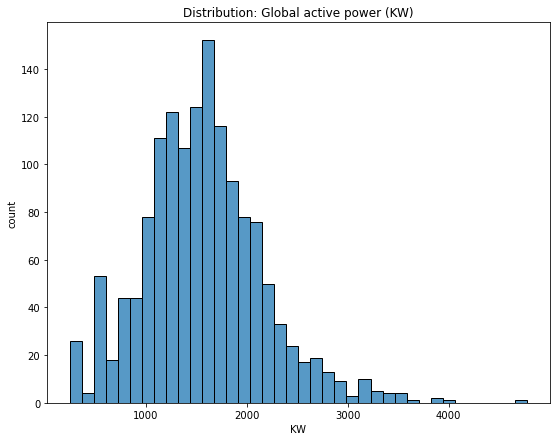

In [27]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['Global_active_power'], bins = num_bins)
# n, b, _ = plt.hist(data['Global_active_power'])
plt.xlabel("KW")
plt.ylabel("count")
plt.title("Distribution: Global active power (KW)")
plt.show()

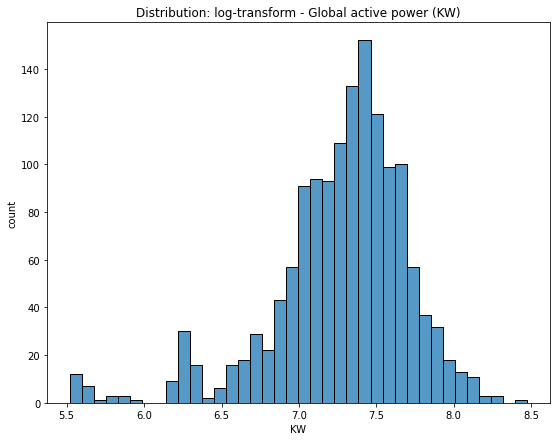

In [28]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.log(data['Global_active_power']), bins = num_bins)
plt.xlabel("KW")
plt.ylabel("count")
plt.title("Distribution: log-transform - Global active power (KW)")
plt.show()

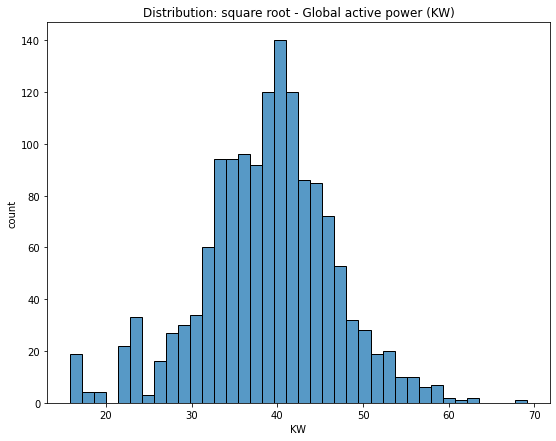

In [29]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.sqrt(data['Global_active_power']), bins = num_bins)
plt.xlabel("KW")
plt.ylabel("count")
plt.title("Distribution: square root - Global active power (KW)")
plt.show()

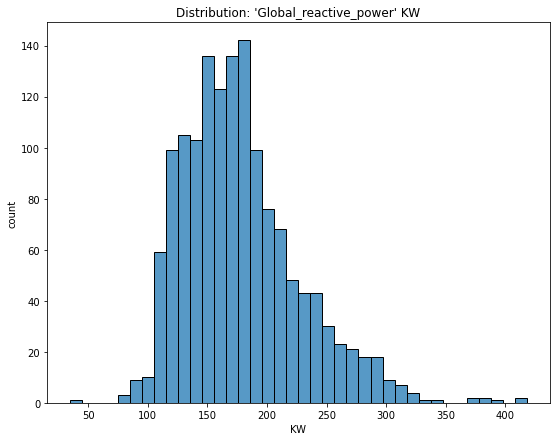

In [32]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['Global_reactive_power'], bins = num_bins)
plt.xlabel("KW")
plt.ylabel("count")
plt.title("Distribution: 'Global_reactive_power' KW")
plt.show()

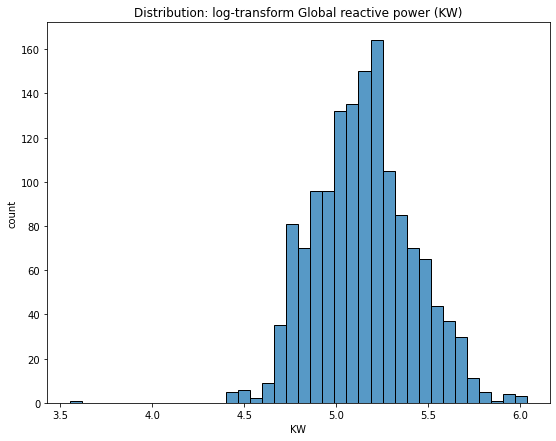

In [33]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.log(data['Global_reactive_power']), bins = num_bins)
plt.xlabel("KW")
plt.ylabel("count")
plt.title("Distribution: log-transform Global reactive power (KW)")
plt.show()

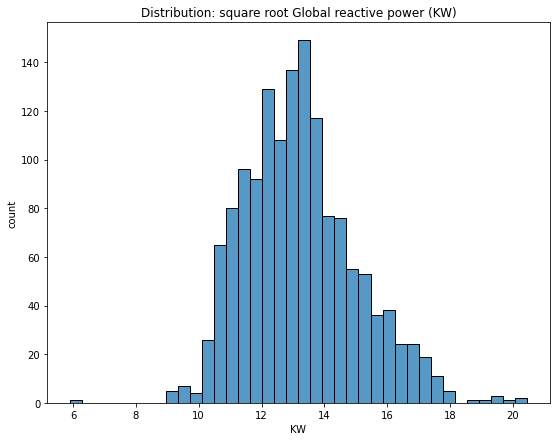

In [34]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.sqrt(data['Global_reactive_power']), bins = num_bins)
plt.xlabel("KW")
plt.ylabel("count")
plt.title("Distribution: square root Global reactive power (KW)")
plt.show()

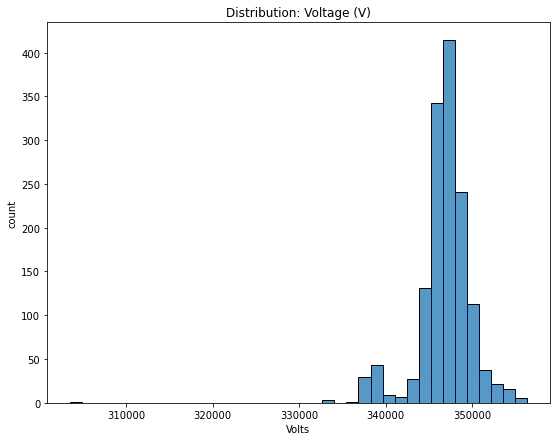

In [35]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['Voltage'], bins = num_bins)
plt.xlabel("Volts")
plt.ylabel("count")
plt.title("Distribution: Voltage (V)")
plt.show()

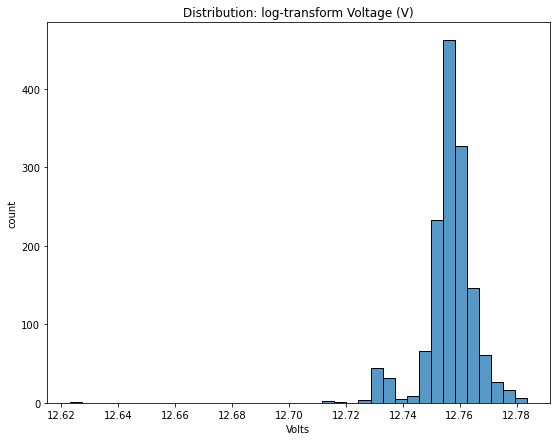

In [36]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.log(data['Voltage']), bins = num_bins)
plt.xlabel("Volts")
plt.ylabel("count")
plt.title("Distribution: log-transform Voltage (V)")
plt.show()

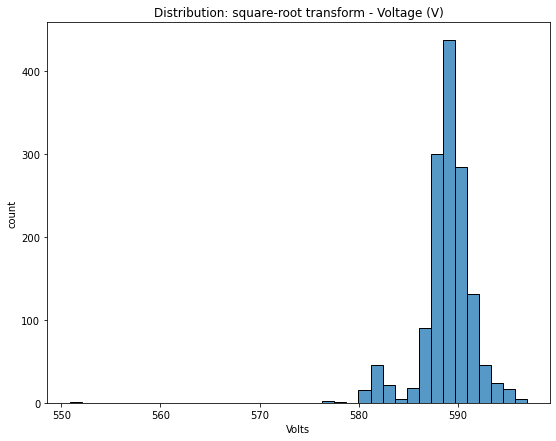

In [37]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.sqrt(data['Voltage']), bins = num_bins)
plt.xlabel("Volts")
plt.ylabel("count")
plt.title("Distribution: square-root transform - Voltage (V)")
plt.show()

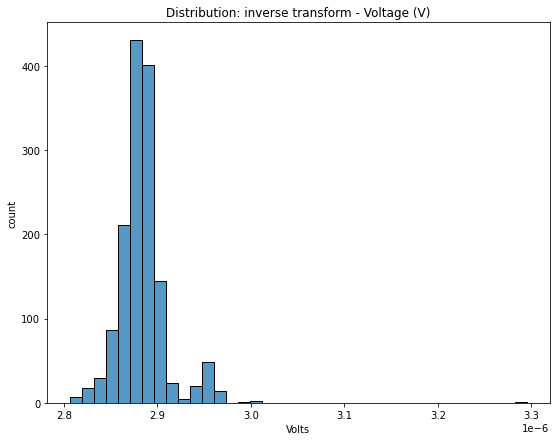

In [38]:
plt.figure(figsize = (9, 7))
sns.histplot(data = 1 / data['Voltage'], bins = num_bins)
plt.xlabel("Volts")
plt.ylabel("count")
plt.title("Distribution: inverse transform - Voltage (V)")
plt.show()

In [39]:
from scipy.stats import boxcox, yeojohnson

#### Box-cox transformation

__Requires values to be strictly positive__.

All the values of ```lambda``` vary from -5 to 5 are considered and the best value for the data is selected. The _best_ value is one that results in the best skewness of the distribution. Log transformation will take place when we have lambda is zero.

[Reference](https://towardsdatascience.com/types-of-transformations-for-better-normal-distribution-61c22668d3b9)

In [40]:
# Box-cox transformation-
bcx_target, lam = boxcox(data["Voltage"])
print(f"best lambda found for distribution = {lam:.3f}")
# lam is the best lambda for the distribution

best lambda found for distribution = 24.413


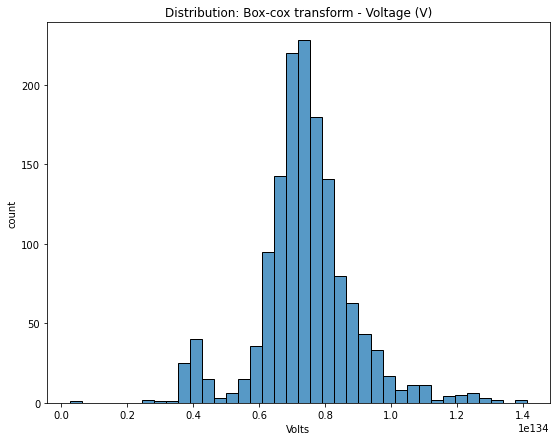

In [41]:
plt.figure(figsize = (9, 7))
sns.histplot(data = bcx_target, bins = num_bins)
plt.xlabel("Volts")
plt.ylabel("count")
plt.title("Distribution: Box-cox transform - Voltage (V)")
plt.show()

### Yeo-Johnson Transformation:

- This is one of the older transformation technique which is similar to Box-cox transformation but __does not require the values to be strictly positive__.

- This transformation is also has the ability to make the distribution more symmetric.

[Reference](https://towardsdatascience.com/types-of-transformations-for-better-normal-distribution-61c22668d3b9)

In [42]:
yj_transform, lam = yeojohnson(data['Voltage'])
print(f"best lambda for 'Voltage' = {lam:.3f}")

best lambda for 'Voltage' = 24.413


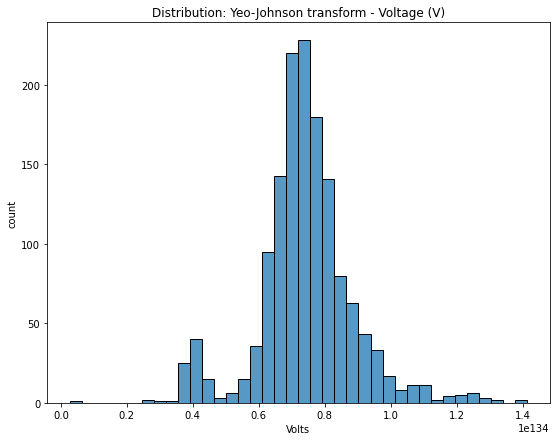

In [43]:
plt.figure(figsize = (9, 7))
sns.histplot(data = yj_transform, bins = num_bins)
plt.xlabel("Volts")
plt.ylabel("count")
plt.title("Distribution: Yeo-Johnson transform - Voltage (V)")
plt.show()

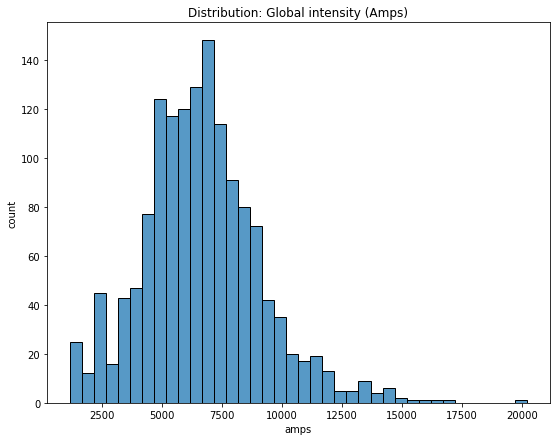

In [44]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['Global_intensity'], bins = num_bins)
plt.xlabel("amps")
plt.ylabel("count")
plt.title("Distribution: Global intensity (Amps)")
plt.show()

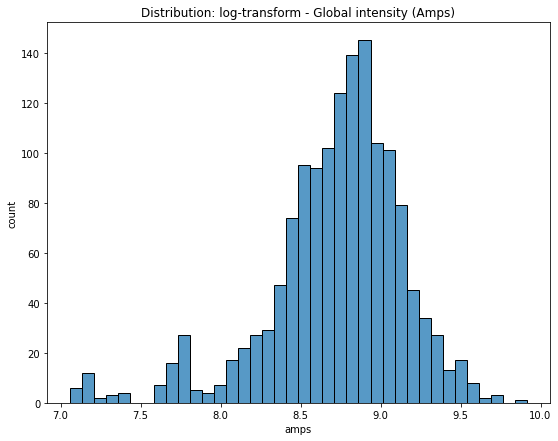

In [45]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.log(data['Global_intensity']), bins = num_bins)
plt.xlabel("amps")
plt.ylabel("count")
plt.title("Distribution: log-transform - Global intensity (Amps)")
plt.show()

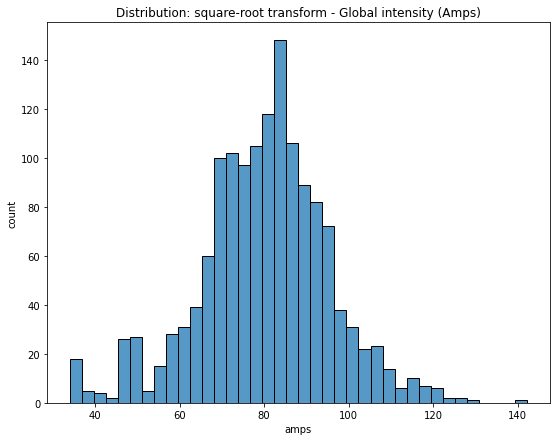

In [46]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.sqrt(data['Global_intensity']), bins = num_bins)
plt.xlabel("amps")
plt.ylabel("count")
plt.title("Distribution: square-root transform - Global intensity (Amps)")
plt.show()

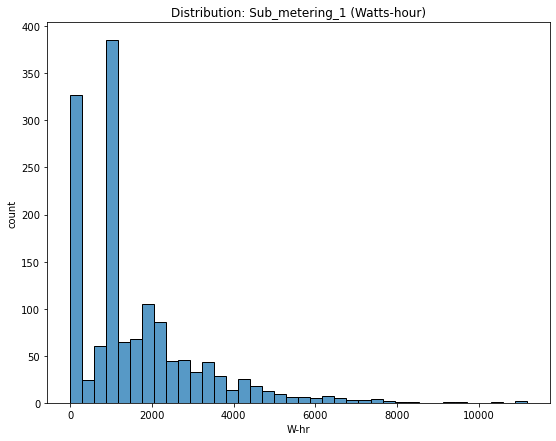

In [47]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['Sub_metering_1'], bins = num_bins)
plt.xlabel("W-hr")
plt.ylabel("count")
plt.title("Distribution: Sub_metering_1 (Watts-hour)")
plt.show()

In [48]:
print(f"number of rows having 'Sub_metering_1' = 0 are {len(data[data['Sub_metering_1'] == 0])}")

number of rows having 'Sub_metering_1' = 0 are 311


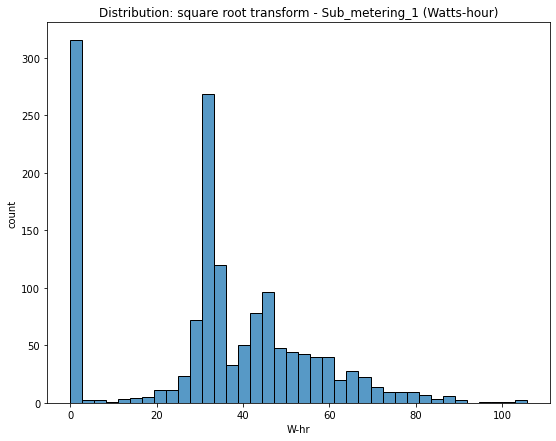

In [49]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.sqrt(data['Sub_metering_1']), bins = num_bins)
plt.xlabel("W-hr")
plt.ylabel("count")
plt.title("Distribution: square root transform - Sub_metering_1 (Watts-hour)")
plt.show()

In [50]:
yj_transform, lam = yeojohnson(data['Sub_metering_1'])
print(f"best lambda for 'Sub_metering_1' = {lam:.3f}")

best lambda for 'Sub_metering_1' = 0.342


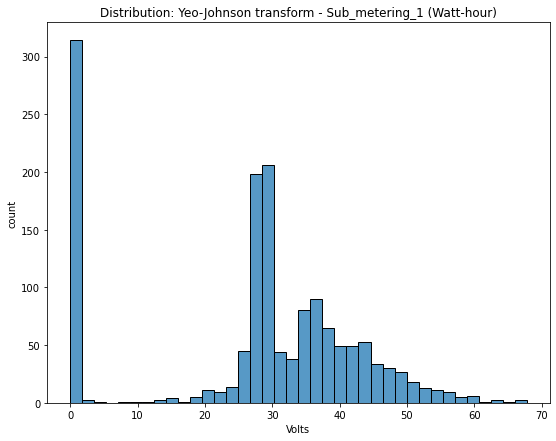

In [51]:
plt.figure(figsize = (9, 7))
sns.histplot(data = yj_transform, bins = num_bins)
plt.xlabel("Volts")
plt.ylabel("count")
plt.title("Distribution: Yeo-Johnson transform - Sub_metering_1 (Watt-hour)")
plt.show()

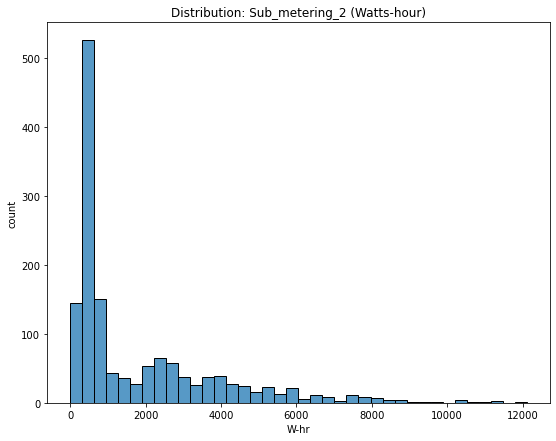

In [52]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['Sub_metering_2'], bins = num_bins)
plt.xlabel("W-hr")
plt.ylabel("count")
plt.title("Distribution: Sub_metering_2 (Watts-hour)")
plt.show()

In [53]:
print(f"number of rows having 'Sub_metering_2' = 0 are {len(data[data['Sub_metering_2'] == 0])}")

number of rows having 'Sub_metering_2' = 0 are 11


C:\Users\Arjun\anaconda3\envs\tensorflow-cpu\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


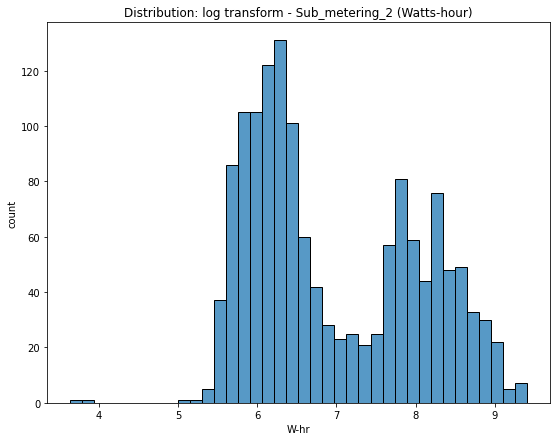

In [54]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.log(data['Sub_metering_2']), bins = num_bins)
plt.xlabel("W-hr")
plt.ylabel("count")
plt.title("Distribution: log transform - Sub_metering_2 (Watts-hour)")
plt.show()

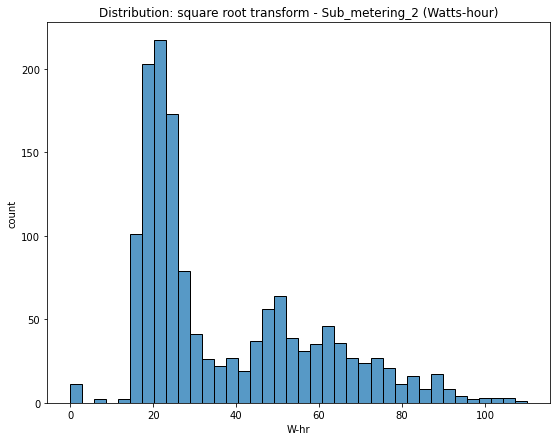

In [55]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.sqrt(data['Sub_metering_2']), bins = num_bins)
plt.xlabel("W-hr")
plt.ylabel("count")
plt.title("Distribution: square root transform - Sub_metering_2 (Watts-hour)")
plt.show()

In [56]:
yj_transform, lam = yeojohnson(data['Sub_metering_2'])
print(f"best lambda for 'Sub_metering_2' = {lam:.3f}")

best lambda for 'Sub_metering_2' = 0.132


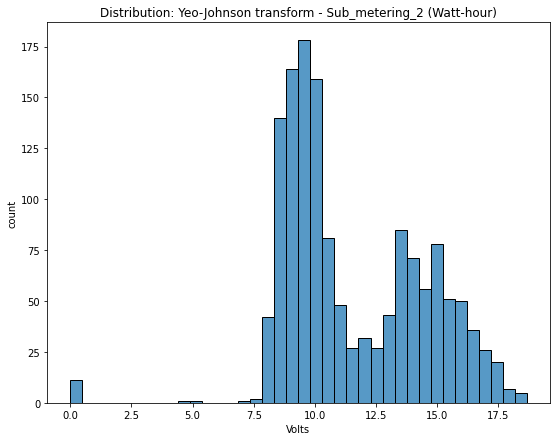

In [57]:
plt.figure(figsize = (9, 7))
sns.histplot(data = yj_transform, bins = num_bins)
plt.xlabel("Volts")
plt.ylabel("count")
plt.title("Distribution: Yeo-Johnson transform - Sub_metering_2 (Watt-hour)")
plt.show()

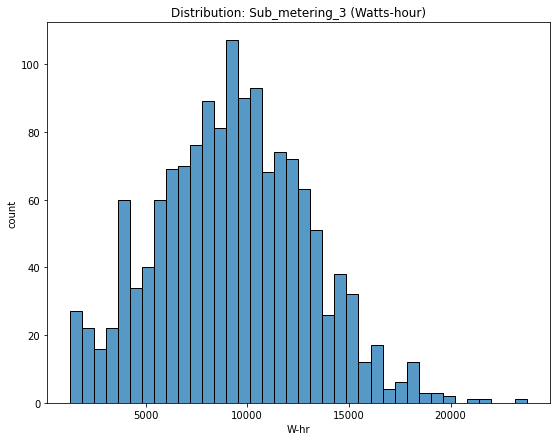

In [58]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['Sub_metering_3'], bins = num_bins)
plt.xlabel("W-hr")
plt.ylabel("count")
plt.title("Distribution: Sub_metering_3 (Watts-hour)")
plt.show()

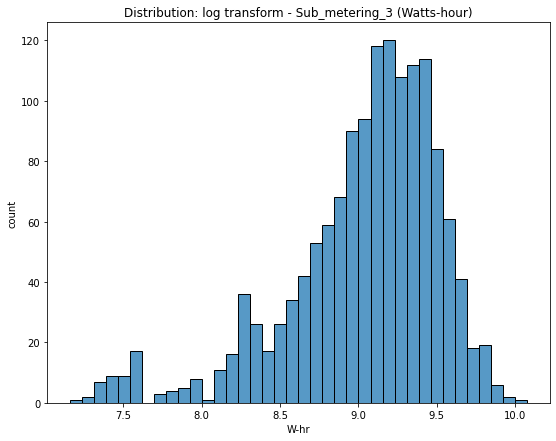

In [59]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.log(data['Sub_metering_3']), bins = num_bins)
plt.xlabel("W-hr")
plt.ylabel("count")
plt.title("Distribution: log transform - Sub_metering_3 (Watts-hour)")
plt.show()

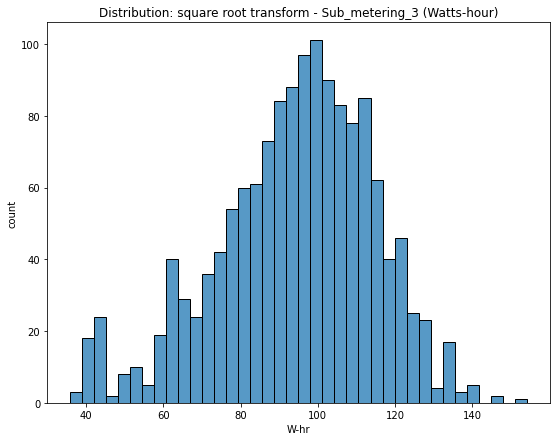

In [60]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.sqrt(data['Sub_metering_3']), bins = num_bins)
plt.xlabel("W-hr")
plt.ylabel("count")
plt.title("Distribution: square root transform - Sub_metering_3 (Watts-hour)")
plt.show()

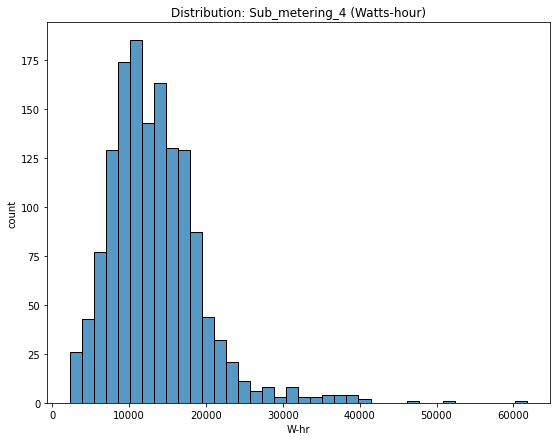

In [61]:
plt.figure(figsize = (9, 7))
sns.histplot(data = data['sub_metering_4'], bins = num_bins)
plt.xlabel("W-hr")
plt.ylabel("count")
plt.title("Distribution: Sub_metering_4 (Watts-hour)")
plt.show()

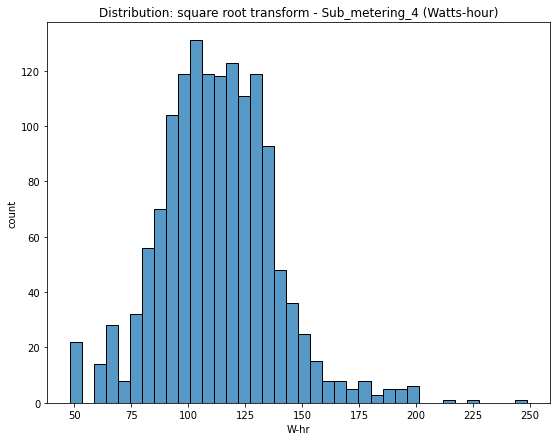

In [62]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.sqrt(data['sub_metering_4']), bins = num_bins)
plt.xlabel("W-hr")
plt.ylabel("count")
plt.title("Distribution: square root transform - Sub_metering_4 (Watts-hour)")
plt.show()

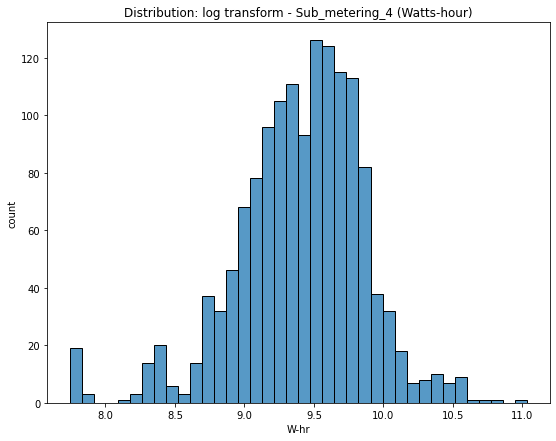

In [63]:
plt.figure(figsize = (9, 7))
sns.histplot(data = np.log(data['sub_metering_4']), bins = num_bins)
plt.xlabel("W-hr")
plt.ylabel("count")
plt.title("Distribution: log transform - Sub_metering_4 (Watts-hour)")
plt.show()

### Feature-wise required transformations

Takeaway from different transforms above are:

1. _Global_active_power_ - square root transform
2. _Global_reactive_power_ - square root transform
3. _Voltage_ - Box-cox/Yeo-johnson transform
4. _Global_intensity_ - square root transform
5. _Sub_metering_1_ - Yeo-Johnson transform
6. _Sub_metering_2_ - Yeo-Johnson transform
7. _Sub_metering_3_ - square root transform
8. _sub_metering_4_ - log transform

In [64]:
# Python3 dict to contain transformed data-
data_transformed = {}

In [65]:
data_transformed['Global_active_power'] = np.sqrt(data['Global_active_power'])
data_transformed['Global_reactive_power'] = np.sqrt(data['Global_reactive_power'])

In [66]:
yf_target, lam = yeojohnson(data['Voltage'])
data_transformed['Voltage'] = yf_target

In [67]:
data_transformed['Global_intensity'] = np.sqrt(data['Global_intensity'])

In [68]:
yj_sm1, _ = yeojohnson(data['Sub_metering_1'])
yj_sm2, _ = yeojohnson(data['Sub_metering_2'])
data_transformed['Sub_metering_1'] = yj_sm1
data_transformed['Sub_metering_2'] = yj_sm2

In [69]:
data_transformed['Sub_metering_3'] = np.sqrt(data['Sub_metering_3'])
data_transformed['Sub_metering_4'] = np.log(data['sub_metering_4'])

In [70]:
# Sanity check-
data_transformed.keys()

dict_keys(['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_4'])

In [71]:
data_transformed = pd.DataFrame(data_transformed)

In [72]:
data_transformed.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
0,34.773208,5.909484,7.196134e+133,71.977774,0.000000,9.843255,70.185469,9.594305
1,58.227657,15.033496,6.765380e+133,119.994167,36.581063,15.218632,115.503247,10.517231
2,46.944925,12.719748,7.598391e+133,96.162363,28.735566,13.850917,118.397635,9.853690
3,40.819040,12.285846,8.211193e+133,84.225887,26.279056,17.087464,78.721026,9.482800
4,47.177834,12.688499,8.470815e+133,96.503886,0.000000,13.879942,118.587520,9.922545


In [73]:
# Compute pearson's correlation coefficient-
data_pearson_Corr = data.corr()

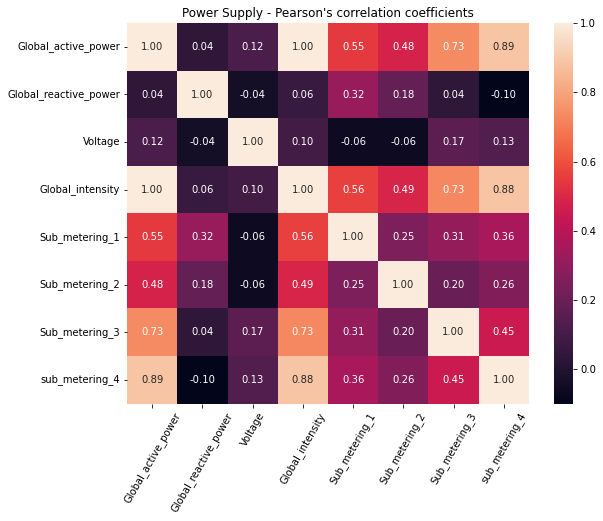

In [74]:
# Visualize correlation coefficients as heatmap-
plt.figure(figsize = (9, 7))
sns.heatmap(data = data_pearson_Corr, annot = True, fmt = '.2f')
plt.title("Power Supply - Pearson's correlation coefficients")
plt.xticks(rotation = 60)
plt.show()

In [75]:
# Scale dataset-
std_scaler = StandardScaler()
# data_scaled = std_scaler.fit_transform(data)
data_scaled = std_scaler.fit_transform(data_transformed)

In [76]:
# Sanity check-
data.shape, data_scaled.shape

((1442, 8), (1442, 8))

In [77]:
# Sanity check-
for i in range(data_scaled.shape[1]):
    print(f"attribute: {i + 1}; min = {data_scaled[:, i].min():.3f}"
          f" & max = {data_scaled[:, i].max():.3f}")

attribute: 1; min = -2.964 & max = 3.898
attribute: 2; min = -4.120 & max = 4.066
attribute: 3; min = -4.909 & max = 4.584
attribute: 4; min = -2.956 & max = 3.998
attribute: 5; min = -1.669 & max = 2.487
attribute: 6; min = -3.952 & max = 2.433
attribute: 7; min = -2.873 & max = 2.953
attribute: 8; min = -3.572 & max = 3.514


#### Reshape _input_ data for LSTM neural network

The input to an LSTM network is a 3D array- ```(samples, timesteps, features)```

- samples — total number of sequences constructed for training.

- timesteps — the length of the samples (aka _look-back_).

- features — number of features/attributes/channels used.

Therefore, first convert this data from 2D into 3D array.

__Predict ```Global_active_power``` feature__.

In [78]:
def slicer(data, look_back = 10, future_window = 3):
    '''
    Create features and labels required for Multivariate Multi-step
    Forecasting by Seq2Seq deep learning models.
    
    NOTE: Target attribute is 'temp' which occurs in first position of 'data'.
    '''
    # Python3 lists to contain training data and target-
    X, y = list(), list()
    
    # Counter to loop through the 2-D matrix dataset to create 'X' and 'y'-
    i = look_back
    
    while i <= (len(data) - future_window):
        X.append(data[i - look_back: i, :])
    
        # This does NOT include the current target value for 'i' but rather
        # i + 1 and i + 2-
        y.append(data[i: i + future_window, 0])
    
        # This INCLUDES the current target value for 'i', as in-
        # i and i + 1-
        # X[i - 1: i + future_window - 1, 2]
    
        i += 1

    # Convert from list to np arrays-
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, y


### Define hyper-parameters for _Multi step_ Sequence Modeling

In [79]:
# Number of lags (hours back) or look back-
look_back = 48

# Steps ahead to forecast-
future_window = 10

In [80]:
# Get features 'X' and labels 'y' using processed data-
X, y = slicer(
    data = data_scaled,
    look_back = look_back, future_window = future_window
)

In [81]:
# Sanity check-
X.shape, y.shape

((1385, 48, 8), (1385, 10))

In [82]:
data_scaled.shape

(1442, 8)

In [ ]:
# Sanity check-
# data_scaled[:49, :]

In [ ]:
# Sanity check-
# X[0]

In [ ]:
# y[0]

In [ ]:
# data_scaled[48:58, 0]

In [83]:
np.all(y[0] == data_scaled[48:58, 0])

True

In [84]:
# Validation data size-
val_size = 0.2
# Use 20% of data as validation data.

In [85]:
# Split data into train and testing sets-
X_train = X[0:int(len(X) * (1 - val_size))]
X_test = X[int(len(X) * (1 - val_size)):]

In [86]:
# Create training and testing labels-
y_train = y[0:int(len(y) * (1 - val_size))]
y_test = y[int(len(y) * (1 - val_size)):]

In [87]:
# Sanity check-
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (1108, 48, 8), y_train.shape: (1108, 10)
X_test.shape: (277, 48, 8), y_test.shape: (277, 10)


In [88]:
print(f"number of lag/look-back = {X_train.shape[1]} & number of features = {X_train.shape[2]}")
print(f"number of feature output = {y_train.shape[1]}")

number of lag/look-back = 48 & number of features = 8
number of feature output = 10


### Define _LSTM_ & _GRU_ architectures

In [102]:
def Single_GRU(X, y):
    # Function to define single layer GRU architecture.
    model = Sequential()
    
    model.add(
        GRU(
            # units = 100, activation = tf.keras.activations.tanh,
            units = 64, activation = 'tanh',
            input_shape = (X.shape[1], X.shape[2]),
            return_sequences = False, return_state = False
        )
    )
    
    # model.add(Dropout(0.2))
    
    model.add(
        Dense(units = y.shape[1])
    )
    
    return model


In [103]:
def Stacked_GRU(X, y):
    # Function to define stacked GRU architecture.
    model = Sequential()

    # Stack of LSTMs-
    model.add(
        GRU(
            units = 64, activation = 'tanh',
            input_shape = (X.shape[1], X.shape[2]),
            return_sequences = True, return_state = False
        )
    )
    # return sequence for the next GRU to process.
    
    model.add(
        GRU(
            units = 64, activation = 'tanh',
            return_sequences = True, return_state = False
        )
    )

    model.add(
        GRU(
            units = 32, activation = 'tanh',
            return_sequences = False
        )
    )

    # model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model


In [104]:
def Stacked_Bi_GRU(X, y):
    # Function to define stacked Bidirectional GRU architecture.
    model = Sequential()
    
    model.add(
        Bidirectional(
            GRU(units = 64, return_sequences = True), input_shape = (X.shape[1], X.shape[2])
        )
    )
    
    model.add(
        Bidirectional(
            GRU(units = 64, return_sequences = True)
        )
    )
    
    model.add(
        Bidirectional(
            GRU(units = 32, return_sequences = False)
        )
    )
    
    # model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model


In [105]:
def Single_LSTM(X, y):
    # Function to define single layer LSTM architecture.
    model = Sequential()

    model.add(
        LSTM(
            units = 64, activation = tf.keras.activations.tanh,
            input_shape = (X.shape[1], X.shape[2]),
            return_sequences = False
        )
    )
    
    # model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model


In [106]:
def Stacked_LSTM(X, y):
    # Function to define stacked LSTM architecture.
    model = Sequential()

    # Stack of LSTMs-
    model.add(
        LSTM(
            units = 64, activation = tf.keras.activations.tanh,
            input_shape = (X.shape[1], X.shape[2]),
            return_sequences = True
        )
    )
    # return sequence for the next LSTM to process.
    
    model.add(
        LSTM(
            units = 64, activation = tf.keras.activations.tanh,
            return_sequences = True
        )
    )

    model.add(
        LSTM(
            units = 32, activation = tf.keras.activations.tanh,
            return_sequences = False
        )
    )

    # model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model

In [107]:
def Stacked_Bi_LSTM(X, y):
    # Function to define stacked Bidirectional LSTM architecture.
    model = Sequential()
    
    model.add(
        Bidirectional(
            LSTM(
                units = 64, return_sequences = True,
            ),
            input_shape = (X.shape[1], X.shape[2])
        )
    )
    
    model.add(
        Bidirectional(
            LSTM(
                units = 64, return_sequences = True,
            )
        )
    )
    
    model.add(
        Bidirectional(
            LSTM(
                units = 32, return_sequences = False,
            )
        )
    )
    
    # model.add(Dropout(0.2))

    model.add(
        Dense(
            units = y.shape[1]
        )
    )

    return model


In [108]:
# Initialize single layer GRU model-
single_model_gru = Single_GRU(X = X_train, y = y_train)

In [109]:
# Initialize stacked GRU model-
stacked_model_gru = Stacked_GRU(X = X_train, y = y_train)

In [110]:
# Initialize bi-directional stacked GRU model-
stacked_bi_model_gru = Stacked_Bi_GRU(X = X_train, y = y_train)

In [111]:
# Instantiate single layer LSTM model-
single_model = Single_LSTM(X = X_train, y = y_train)

In [112]:
# Instantiate stacked LSTM model-
stacked_model = Stacked_LSTM(X = X_train, y = y_train)

In [113]:
# Instantiate stacked bi-directional LSTM-
stacked_bi_model = Stacked_Bi_LSTM(X = X_train, y = y_train)

In [114]:
# Sanity check-
pred_single = single_model(X_train[:2])
pred_stacked = stacked_model(X_train[:2])
pred_bi_stacked = stacked_bi_model(X_train[:2])

In [115]:
# Sanity check-
pred_single = single_model_gru(X_train[:2])
pred_stacked = stacked_model_gru(X_train[:2])
pred_bi_stacked = stacked_bi_model_gru(X_train[:2])

In [116]:
print(f"Single layer LSTM output shape: {pred_single.shape},"
      f" Stacked LSTM output shape: {pred_stacked.shape}, "
      f"Bi-directional Stacked LSTM output shape: {pred_bi_stacked.shape}"
      f" & ground truth output shape: {y_train[:2].shape}")

Single layer LSTM output shape: (2, 10), Stacked LSTM output shape: (2, 10), Bi-directional Stacked LSTM output shape: (2, 10) & ground truth output shape: (2, 10)


In [117]:
print(f"Single layer GRU output shape: {pred_single.shape},"
      f" Stacked GRU output shape: {pred_stacked.shape}, "
      f"Bi-directional Stacked GRU output shape: {pred_bi_stacked.shape}"
      f" & ground truth output shape: {y_train[:2].shape}")

Single layer GRU output shape: (2, 10), Stacked GRU output shape: (2, 10), Bi-directional Stacked GRU output shape: (2, 10) & ground truth output shape: (2, 10)


In [118]:
# Compile defined model-
single_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [119]:
stacked_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [120]:
stacked_bi_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [121]:
# Compile defined model-
single_model_gru.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [122]:
# Compile defined model-
stacked_model_gru.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [123]:
# Compile defined model-
stacked_bi_model_gru.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
    loss = tf.keras.losses.MeanSquaredError()
)

In [124]:
# Get model summary-
single_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                18688     
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
Total params: 19,338
Trainable params: 19,338
Non-trainable params: 0
_________________________________________________________________


In [125]:
stacked_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 48, 64)            18688     
                                                                 
 lstm_9 (LSTM)               (None, 48, 64)            33024     
                                                                 
 lstm_10 (LSTM)              (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 10)                330       
                                                                 
Total params: 64,458
Trainable params: 64,458
Non-trainable params: 0
_________________________________________________________________


In [126]:
stacked_bi_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 48, 128)          37376     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 48, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 178,058
Trainable params: 178,058
Non-trainable params: 0
_______________________________________________

In [127]:
single_model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 64)                14208     
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
Total params: 14,858
Trainable params: 14,858
Non-trainable params: 0
_________________________________________________________________


In [128]:
stacked_model_gru.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 48, 64)            14208     
                                                                 
 gru_9 (GRU)                 (None, 48, 64)            24960     
                                                                 
 gru_10 (GRU)                (None, 32)                9408      
                                                                 
 dense_7 (Dense)             (None, 10)                330       
                                                                 
Total params: 48,906
Trainable params: 48,906
Non-trainable params: 0
_________________________________________________________________


In [129]:
stacked_bi_model_gru.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 48, 128)          28416     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 48, 128)          74496     
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 134,666
Trainable params: 134,666
Non-trainable params: 0
________________________________________________

In [130]:
# Define early stopping criterion-
early_stopping_criterion = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", min_delta = 0,
    patience = 5, verbose = 0,
    mode = "auto", baseline = None,
    restore_best_weights = True,
)


In [131]:
# Train single-layer LSTM model-
train_history_lstm = single_model.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 512,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
3/3 [==============================] - 6s 768ms/step - loss: 0.8438 - val_loss: 0.4135
Epoch 2/50
3/3 [==============================] - 1s 203ms/step - loss: 0.6370 - val_loss: 0.3730
Epoch 3/50
3/3 [==============================] - 1s 210ms/step - loss: 0.5995 - val_loss: 0.3631
Epoch 4/50
3/3 [==============================] - 1s 208ms/step - loss: 0.5779 - val_loss: 0.3888
Epoch 5/50
3/3 [==============================] - 1s 202ms/step - loss: 0.5702 - val_loss: 0.3596
Epoch 6/50
3/3 [==============================] - 1s 215ms/step - loss: 0.5581 - val_loss: 0.3573
Epoch 7/50
3/3 [==============================] - 1s 185ms/step - loss: 0.5520 - val_loss: 0.3586
Epoch 8/50
3/3 [==============================] - 1s 195ms/step - loss: 0.5450 - val_loss: 0.3630
Epoch 9/50
3/3 [==============================] - 1s 186ms/step - loss: 0.5361 - val_loss: 0.3451
Epoch 10/50
3/3 [==============================] - 1s 195ms/step - loss: 0.5219 - val_loss: 0.3421
Epoch 11/50
3/3 [==

In [132]:
# Train stacked LSTM model-
train_history_stacked_lstm = stacked_model.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 512,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
3/3 [==============================] - 16s 2s/step - loss: 0.9213 - val_loss: 0.4303
Epoch 2/50
3/3 [==============================] - 2s 538ms/step - loss: 0.6988 - val_loss: 0.4472
Epoch 3/50
3/3 [==============================] - 2s 565ms/step - loss: 0.6817 - val_loss: 0.4759
Epoch 4/50
3/3 [==============================] - 2s 580ms/step - loss: 0.6319 - val_loss: 0.3663
Epoch 5/50
3/3 [==============================] - 2s 573ms/step - loss: 0.5980 - val_loss: 0.3735
Epoch 6/50
3/3 [==============================] - 2s 559ms/step - loss: 0.5797 - val_loss: 0.4037
Epoch 7/50
3/3 [==============================] - 2s 454ms/step - loss: 0.5773 - val_loss: 0.3924
Epoch 8/50
3/3 [==============================] - 1s 449ms/step - loss: 0.5442 - val_loss: 0.3640
Epoch 9/50
3/3 [==============================] - 1s 511ms/step - loss: 0.5279 - val_loss: 0.4460
Epoch 10/50
3/3 [==============================] - 2s 555ms/step - loss: 0.5025 - val_loss: 0.3935
Epoch 11/50
3/3 [====

In [133]:
# Train bi-directional stacked LSTM model-
train_history_bi_stacked_lstm = stacked_bi_model.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 512,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
3/3 [==============================] - 29s 3s/step - loss: 0.9273 - val_loss: 0.4799
Epoch 2/50
3/3 [==============================] - 3s 959ms/step - loss: 0.7115 - val_loss: 0.5353
Epoch 3/50
3/3 [==============================] - 3s 973ms/step - loss: 0.6548 - val_loss: 0.4314
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 0.5970 - val_loss: 0.3861
Epoch 5/50
3/3 [==============================] - 3s 992ms/step - loss: 0.5647 - val_loss: 0.4116
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 0.5433 - val_loss: 0.4497
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 0.5176 - val_loss: 0.4546
Epoch 8/50
3/3 [==============================] - 4s 1s/step - loss: 0.4975 - val_loss: 0.4772
Epoch 9/50
3/3 [==============================] - 4s 1s/step - loss: 0.4850 - val_loss: 0.4476


In [134]:
# Train single-layer GRU model-
train_history_gru_single = single_model_gru.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 512,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
3/3 [==============================] - 6s 674ms/step - loss: 0.9909 - val_loss: 0.4289
Epoch 2/50
3/3 [==============================] - 0s 163ms/step - loss: 0.6668 - val_loss: 0.3964
Epoch 3/50
3/3 [==============================] - 1s 172ms/step - loss: 0.6150 - val_loss: 0.3875
Epoch 4/50
3/3 [==============================] - 1s 176ms/step - loss: 0.6014 - val_loss: 0.3770
Epoch 5/50
3/3 [==============================] - 0s 157ms/step - loss: 0.5850 - val_loss: 0.3715
Epoch 6/50
3/3 [==============================] - 0s 159ms/step - loss: 0.5750 - val_loss: 0.3728
Epoch 7/50
3/3 [==============================] - 1s 169ms/step - loss: 0.5672 - val_loss: 0.3695
Epoch 8/50
3/3 [==============================] - 1s 171ms/step - loss: 0.5580 - val_loss: 0.3651
Epoch 9/50
3/3 [==============================] - 1s 158ms/step - loss: 0.5499 - val_loss: 0.3624
Epoch 10/50
3/3 [==============================] - 0s 159ms/step - loss: 0.5453 - val_loss: 0.3616
Epoch 11/50
3/3 [==

In [135]:
# Train stacked-layer GRU model-
train_history_gru_stacked = stacked_model_gru.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 512,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
3/3 [==============================] - 16s 2s/step - loss: 0.8866 - val_loss: 0.4135
Epoch 2/50
3/3 [==============================] - 1s 439ms/step - loss: 0.6657 - val_loss: 0.3802
Epoch 3/50
3/3 [==============================] - 1s 454ms/step - loss: 0.6187 - val_loss: 0.3968
Epoch 4/50
3/3 [==============================] - 1s 433ms/step - loss: 0.6001 - val_loss: 0.3701
Epoch 5/50
3/3 [==============================] - 2s 477ms/step - loss: 0.5800 - val_loss: 0.3785
Epoch 6/50
3/3 [==============================] - 1s 459ms/step - loss: 0.5676 - val_loss: 0.3524
Epoch 7/50
3/3 [==============================] - 2s 478ms/step - loss: 0.5511 - val_loss: 0.4060
Epoch 8/50
3/3 [==============================] - 2s 478ms/step - loss: 0.5702 - val_loss: 0.3659
Epoch 9/50
3/3 [==============================] - 2s 490ms/step - loss: 0.5526 - val_loss: 0.3835
Epoch 10/50
3/3 [==============================] - 1s 457ms/step - loss: 0.5483 - val_loss: 0.3700
Epoch 11/50
3/3 [====

In [136]:
# Train bi-directional stacked-layer GRU model-
train_history_bi_stacked_gru = stacked_bi_model_gru.fit(
    x = X_train, y = y_train,
    epochs = 50, batch_size = 512,
    validation_data = (X_test, y_test),
    # validation_split = 0.1, verbose = 1,
    callbacks = [early_stopping_criterion]
)

Epoch 1/50
3/3 [==============================] - 30s 3s/step - loss: 0.9499 - val_loss: 0.4961
Epoch 2/50
3/3 [==============================] - 2s 726ms/step - loss: 0.7163 - val_loss: 0.4088
Epoch 3/50
3/3 [==============================] - 2s 749ms/step - loss: 0.6234 - val_loss: 0.4210
Epoch 4/50
3/3 [==============================] - 3s 785ms/step - loss: 0.5910 - val_loss: 0.3838
Epoch 5/50
3/3 [==============================] - 2s 686ms/step - loss: 0.5719 - val_loss: 0.3988
Epoch 6/50
3/3 [==============================] - 3s 783ms/step - loss: 0.5484 - val_loss: 0.3826
Epoch 7/50
3/3 [==============================] - 3s 815ms/step - loss: 0.5212 - val_loss: 0.3966
Epoch 8/50
3/3 [==============================] - 2s 681ms/step - loss: 0.5058 - val_loss: 0.4115
Epoch 9/50
3/3 [==============================] - 3s 810ms/step - loss: 0.4842 - val_loss: 0.4356
Epoch 10/50
3/3 [==============================] - 3s 806ms/step - loss: 0.4766 - val_loss: 0.4007
Epoch 11/50
3/3 [====

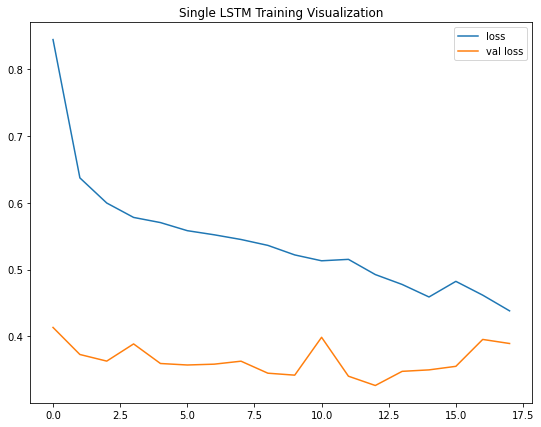

In [137]:
# Visualize training - LSTM model
plt.figure(figsize = (9, 7))
plt.plot(train_history_lstm.history['loss'], label = 'loss')
plt.plot(train_history_lstm.history['val_loss'], label = 'val loss')
plt.title("Single LSTM Training Visualization")
plt.legend(loc = 'best')
plt.show()

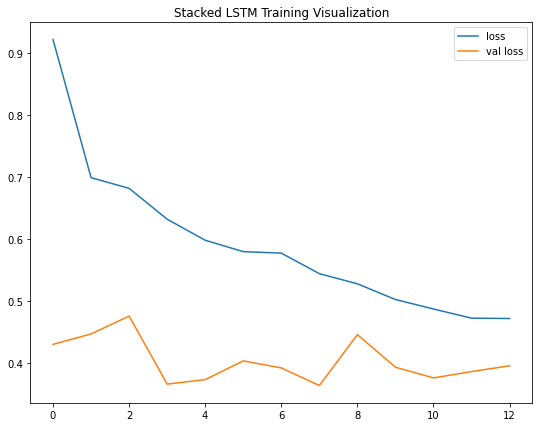

In [138]:
# Visualize training - Stacked LSTM model
plt.figure(figsize = (9, 7))
plt.plot(train_history_stacked_lstm.history['loss'], label = 'loss')
plt.plot(train_history_stacked_lstm.history['val_loss'], label = 'val loss')
plt.title("Stacked LSTM Training Visualization")
plt.legend(loc = 'best')
plt.show()

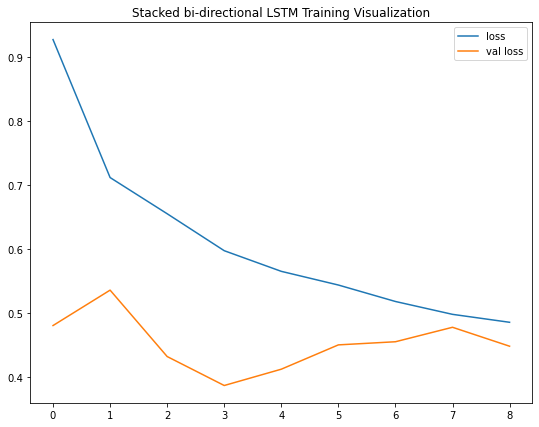

In [139]:
# Visualize training - Stacked LSTM model
plt.figure(figsize = (9, 7))
plt.plot(train_history_bi_stacked_lstm.history['loss'], label = 'loss')
plt.plot(train_history_bi_stacked_lstm.history['val_loss'], label = 'val loss')
plt.title("Stacked bi-directional LSTM Training Visualization")
plt.legend(loc = 'best')
plt.show()

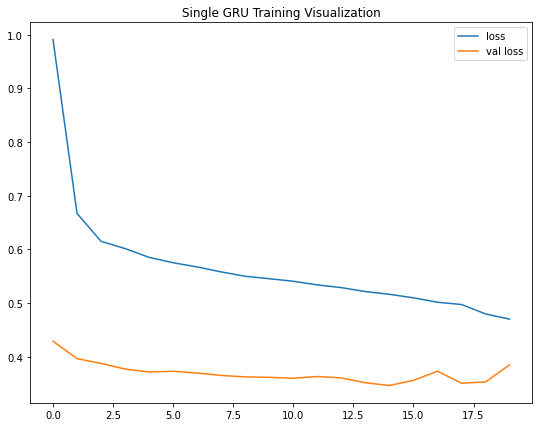

In [140]:
# Visualize training - GRU model
plt.figure(figsize = (9, 7))
plt.plot(train_history_gru_single.history['loss'], label = 'loss')
plt.plot(train_history_gru_single.history['val_loss'], label = 'val loss')
plt.title("Single GRU Training Visualization")
plt.legend(loc = 'best')
plt.show()

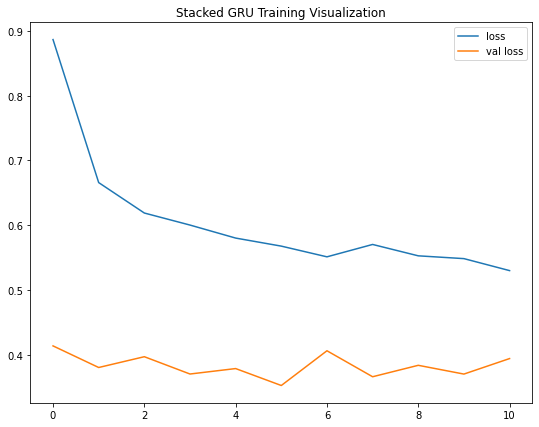

In [141]:
# Visualize training - Stacked GRU model
plt.figure(figsize = (9, 7))
plt.plot(train_history_gru_stacked.history['loss'], label = 'loss')
plt.plot(train_history_gru_stacked.history['val_loss'], label = 'val loss')
plt.title("Stacked GRU Training Visualization")
plt.legend(loc = 'best')
plt.show()

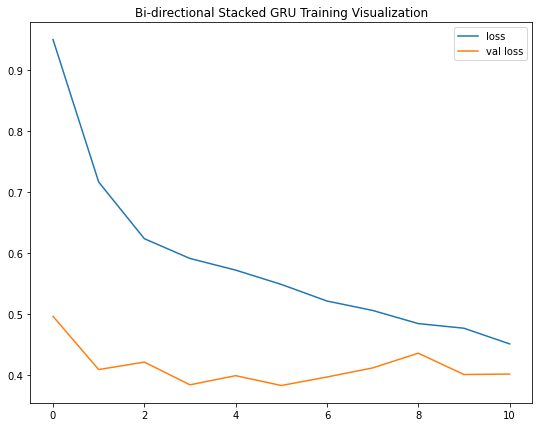

In [142]:
# Visualize training - Bi-directional Stacked GRU model
plt.figure(figsize = (9, 7))
plt.plot(train_history_bi_stacked_gru.history['loss'], label = 'loss')
plt.plot(train_history_bi_stacked_gru.history['val_loss'], label = 'val loss')
plt.title("Bi-directional Stacked GRU Training Visualization")
plt.legend(loc = 'best')
plt.show()

In [143]:
# Get predictions and ground truth for model's performance comparisons-
ground_truth_single = [y[0] for y in y_test]

In [144]:
predictions_single = [y_pred[0] for y_pred in single_model.predict(X_test)]
predictions_stacked = [y_pred[0] for y_pred in stacked_model.predict(X_test)]
predictions_bi_stacked = [y_pred[0] for y_pred in stacked_bi_model.predict(X_test)]

In [145]:
predictions_single_gru = [y_pred[0] for y_pred in single_model_gru.predict(X_test)]
predictions_stacked_gru = [y_pred[0] for y_pred in stacked_model_gru.predict(X_test)]
predictions_stacked_bi_gru = [y_pred[0] for y_pred in stacked_bi_model_gru.predict(X_test)]

In [146]:
# Sanity check-
len(ground_truth_single), len(predictions_single), len(predictions_stacked), len(predictions_bi_stacked), \
len(predictions_single_gru), len(predictions_stacked_gru), len(predictions_stacked_bi_gru)

(277, 277, 277, 277, 277, 277, 277)

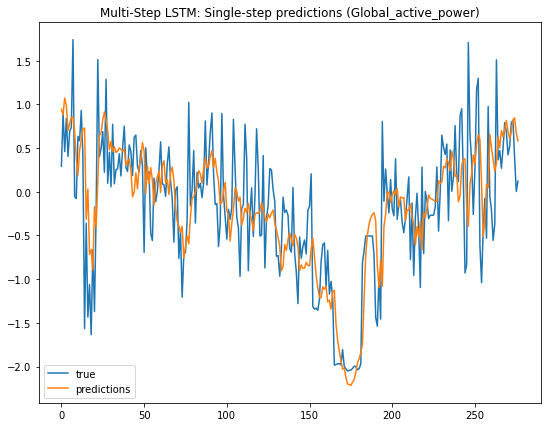

In [147]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_single, label = 'predictions')
plt.title("Multi-Step LSTM: Single-step predictions (Global_active_power)")
plt.legend(loc =  'best')
plt.show()

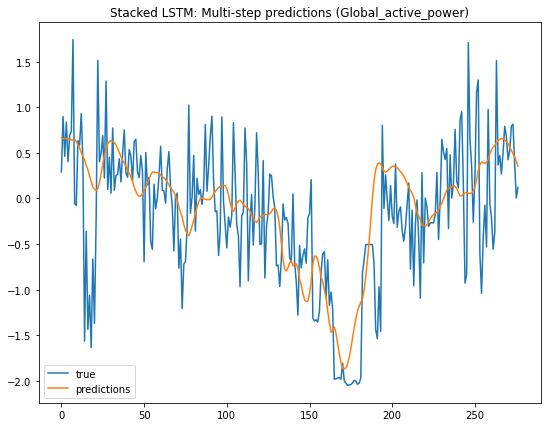

In [148]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_stacked, label = 'predictions')
plt.title("Stacked LSTM: Multi-step predictions (Global_active_power)")
plt.legend(loc =  'best')
plt.show()

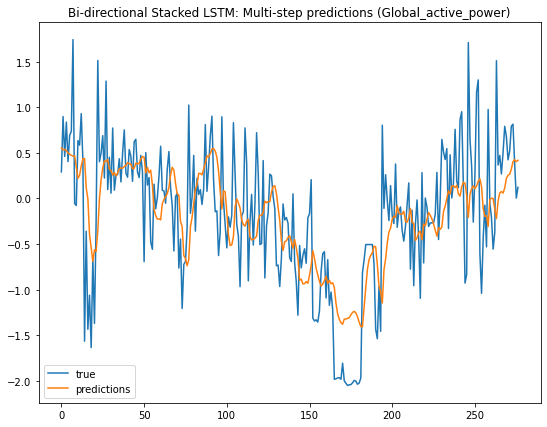

In [149]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_bi_stacked, label = 'predictions')
plt.title("Bi-directional Stacked LSTM: Multi-step predictions (Global_active_power)")
plt.legend(loc =  'best')
plt.show()

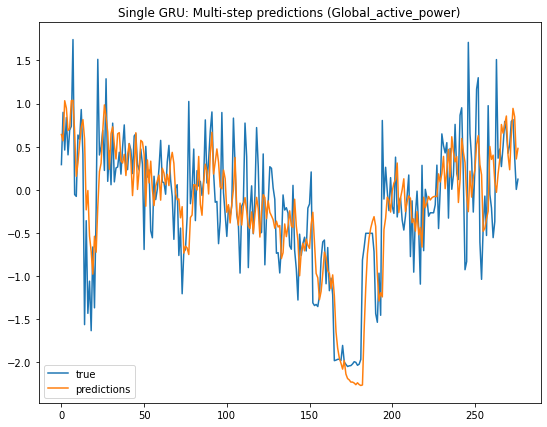

In [150]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_single_gru, label = 'predictions')
plt.title("Single GRU: Multi-step predictions (Global_active_power)")
plt.legend(loc =  'best')
plt.show()

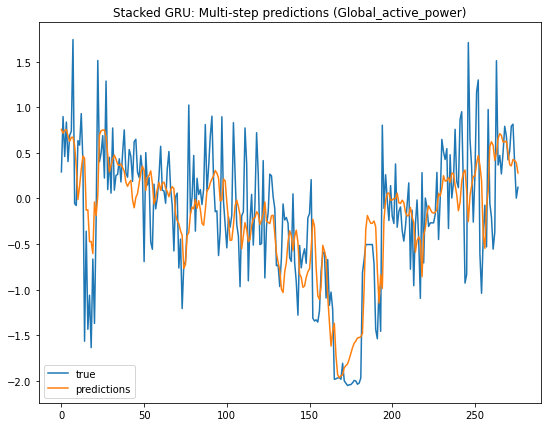

In [151]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_stacked_gru, label = 'predictions')
plt.title("Stacked GRU: Multi-step predictions (Global_active_power)")
plt.legend(loc =  'best')
plt.show()

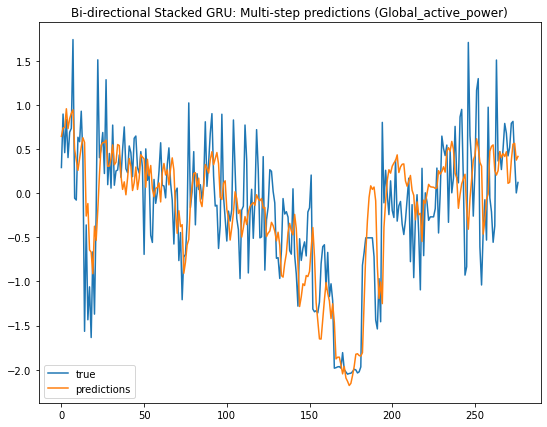

In [152]:
plt.figure(figsize = (9, 7))
plt.plot(ground_truth_single, label = 'true')
plt.plot(predictions_stacked_bi_gru, label = 'predictions')
plt.title("Bi-directional Stacked GRU: Multi-step predictions (Global_active_power)")
plt.legend(loc =  'best')
plt.show()

In [153]:
# Compute MAE-
mae_single = mean_absolute_error(y_true = ground_truth_single, y_pred = predictions_single)
mae_stacked = mean_absolute_error(y_true = ground_truth_single, y_pred = predictions_stacked)
mae_bi_stacked = mean_absolute_error(y_true = ground_truth_single, y_pred = predictions_bi_stacked)
mae_single_gru = mean_absolute_error(y_true = ground_truth_single, y_pred = predictions_single_gru)
mae_stacked_gru = mean_absolute_error(y_true = ground_truth_single, y_pred = predictions_stacked_gru)
mae_bi_stacked_gru = mean_absolute_error(y_true = ground_truth_single, y_pred = predictions_stacked_bi_gru)

In [154]:
# Compute MSE-
mse_single = mean_squared_error(y_true = ground_truth_single, y_pred = predictions_single)
mse_stacked = mean_squared_error(y_true = ground_truth_single, y_pred = predictions_stacked)
mse_bi_stacked = mean_squared_error(y_true = ground_truth_single, y_pred = predictions_bi_stacked)
mse_single_gru = mean_squared_error(y_true = ground_truth_single, y_pred = predictions_single_gru)
mse_stacked_gru = mean_squared_error(y_true = ground_truth_single, y_pred = predictions_stacked_gru)
mse_bi_stacked_gru = mean_squared_error(y_true = ground_truth_single, y_pred = predictions_stacked_bi_gru)

In [155]:
# Compute RMSE-
rmse_single = np.sqrt(mse_single)
rmse_stacked = np.sqrt(mse_stacked)
rmse_bi_stacked = np.sqrt(mse_bi_stacked)
rmse_single_gru = np.sqrt(mse_single_gru)
rmse_stacked_gru = np.sqrt(mse_stacked_gru)
rmse_bi_stacked_gru = np.sqrt(mse_bi_stacked_gru)

In [156]:
print("Validation metrics for different LSTM models are:")
print(f"MAE single = {mae_single:.4f}, MAE stacked = {mae_stacked:.4f} & MAE bi-directional stacked = {mae_bi_stacked:.4f}")
print(f"MSE single = {mse_single:.4f}, MSE stacked = {mse_stacked:.4f} & MSE bi-directional stacked = {mse_bi_stacked:.4f}")
print(f"RMSE single = {rmse_single:.4f}, RMSE stacked = {rmse_stacked:.4f} & RMSE bi-directional stacked = {rmse_bi_stacked:.4f}")

Validation metrics for different LSTM models are:
MAE single = 0.3885, MAE stacked = 0.4505 & MAE bi-directional stacked = 0.4388
MSE single = 0.2751, MSE stacked = 0.3498 & MSE bi-directional stacked = 0.3258
RMSE single = 0.5245, RMSE stacked = 0.5915 & RMSE bi-directional stacked = 0.5708


In [157]:
print("Validation metrics for different GRU models are:")
print(f"MAE single = {mae_single_gru:.4f}, MAE stacked = {mae_stacked_gru:.4f} & MAE bi-directional stacked = {mae_bi_stacked_gru:.4f}")
print(f"MSE single = {mse_single_gru:.4f}, MSE stacked = {mse_stacked_gru:.4f} & MSE bi-directional stacked = {mse_bi_stacked_gru:.4f}")
print(f"RMSE single = {rmse_single_gru:.4f}, RMSE stacked = {rmse_stacked_gru:.4f} & RMSE bi-directional stacked = {rmse_bi_stacked_gru:.4f}")

Validation metrics for different GRU models are:
MAE single = 0.3877, MAE stacked = 0.4022 & MAE bi-directional stacked = 0.4153
MSE single = 0.2777, MSE stacked = 0.2811 & MSE bi-directional stacked = 0.3018
RMSE single = 0.5270, RMSE stacked = 0.5302 & RMSE bi-directional stacked = 0.5493


In [158]:
# Save trained models-
single_model.save_weights("Single_LSTM_power_consumption_model.h5", overwrite = True)
stacked_model.save_weights("Stacked_LSTM_power_consumption_model.h5", overwrite = True)
stacked_bi_model.save_weights("Stacked_bi_Directional_LSTM_power_consumption_model.h5", overwrite = True)

In [159]:
single_model_gru.save_weights("Single_GRU_power_consumption_model.h5", overwrite = True)
stacked_model_gru.save_weights("Stacked_GRU_power_consumption_model.h5", overwrite = True)
stacked_bi_model_gru.save_weights("Stacked_bi_Directional_GRU_power_consumption_model.h5", overwrite = True)

In [128]:
del single_model, stacked_model, stacked_bi_model

In [129]:
del single_model_gru, stacked_model_gru, stacked_bi_model_gru